In [21]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits,ascii
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
plt.style.use('science')

In [5]:
for f in glob.glob('/Users/chrismac/python/stack_spectra/Base_files/*'):
         hdu = fits.open(f)
         data = hdu[1].data
         print(f)
         mask = (data['wave'] > 3100) & (data['wave'] < 5450)
         t = Table((data['wave'][mask],data['flux'][mask],data['sig'][mask]),names=('wave','flux','sig'))
         t.write(f.split('/')[-1].split('_')[0] + '_test.fits',overwrite=True)

/Users/chrismac/python/stack_spectra/Base_files/257_A1689_slitcorr.fits
/Users/chrismac/python/stack_spectra/Base_files/2614_M1149_slitcorr.fits
/Users/chrismac/python/stack_spectra/Base_files/1637_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/470_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/1014_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/1829_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/1751_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/2331_M1149_slitcorr.fits
/Users/chrismac/python/stack_spectra/Base_files/30003_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/1467_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/2223_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/1721_M1149_slitcorr.fits
/Users/chrismac/python/stack_spectra/Base_files/1337_for_stack.fits
/Users/chrismac/python/stack_spectra/Base_files/280_A1689_slitcorr.fits
/Users/chrismac/python/st

In [30]:
data = ascii.read('Full_table.txt')#not available in this folder
cut_list = [363,499,680,991,1037,1059,1212,1451,1488,2395,2889,10012,10013,10030,1000]
LRIS_cut_list = [40000,10030,10013,10004,2889,2395,1488,1471,1451,1212,1117,1059,1037,1000,991,946,680,499]
mask = [False if data['Names'][i] in cut_list else True for i in range(len(data['Names']))]
LRIS_mask = [False if data['Names'][i] in LRIS_cut_list else True for i in range(len(data['Names']))]
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Ob0=0.05,Tcmb0=2.725)
d = cosmo.luminosity_distance(data['Z_Lya']).value
filt_alt = [data['F475W/F435W'][i] if (((data['Z_Lya'][i] < 1.83) and (data['Cluster'][i] != 'A1689')) or ((data['Z_Lya'][i] < 2.24) and (data['Cluster'][i] == 'A1689'))) else data['F625W/F606W'][i] for i in range(len(data['F625W/F606W']))]
filt_alt_err = [data['EF475W/EF435W'][i] if (((data['Z_Lya'][i] < 1.83) and (data['Cluster'][i] != 'A1689')) or ((data['Z_Lya'][i] < 2.24) and (data['Cluster'][i] == 'A1689'))) else data['EF625W/EF606W'][i] for i in range(len(data['EF625W/EF606W']))]
M_UV_alt = -2.5*np.log10(filt_alt)-48.6 - 5*np.log10(d*1e6) + 5 + 2.5*np.log10(data['Z_Lya']+1.0) + data['Magn']
M_UV_alt_err = 2.5*np.array(filt_alt_err)/(np.array(filt_alt)*np.log(10))

In [10]:
filt_alt = np.array(filt_alt)
filt_alt_err = np.array(filt_alt_err)
c1 = fits.Column('ID',format='D',array=data['Names'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)])
c2 = fits.Column('Mask',format='A18',array=['A1689_1']*len(data['Names'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)]))
c3 = fits.Column('Weighted_z',format='D',array=data['Spec_z'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)])
c4 = fits.Column('Weighted_z_sig',format='D',array=[data['Spec_z_err'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)][i] if data['Spec_z_err'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)][i] != -1 else data['Z_Lya_uperr'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)][i] for i in range(len(data['Spec_z'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)]))])
c5 = fits.Column('Multiple_Images',format='L',array=[False]*len(data['Names'][(data['Halpha']>0)&(mask)&(M_UV_alt>-19)]))
c6 = fits.Column('L_UV',format='D',array=filt_alt[(data['Halpha']>0)&(mask)&(M_UV_alt>-19)]*1e30)
c7 = fits.Column('L_UV_sig',format='D',array=filt_alt_err[(data['Halpha']>0)&(mask)&(M_UV_alt>-19)]*1e30)

In [12]:
cols = fits.ColDefs([c1,c2,c3,c4,c5,c6,c7])
T = fits.BinTableHDU.from_columns(cols)
T.writeto('fesc_stack.fits',overwrite=True)

Text(0.5, 0, '$\\lambda\\;\\rm(\\AA)$')

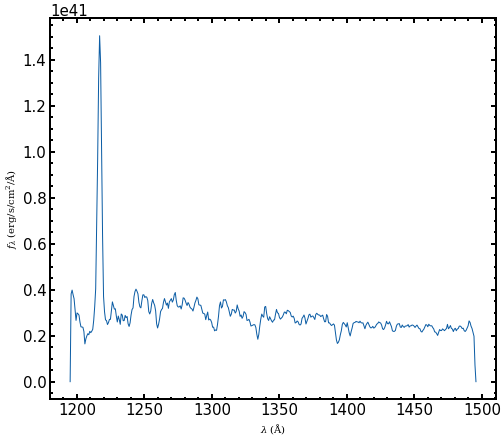

In [22]:
spec = ascii.read('stacked_spectrum_LRIS-bands_weighted-average_Lum_Density_noDC.txt')
fig,ax = plt.subplots(figsize=(8,7))
ax.plot(spec['col1'],spec['col2'])
ax.set_ylabel(r'$f_{\lambda}\;\rm(erg/s/cm^2/\AA)$')
ax.set_xlabel(r'$\lambda\;\rm(\AA)$')

In [32]:
M_UV_alt[data['Names']==40000]

-16.87182552159305
